In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [29]:
pretty_agg_names = {
    'fedavg': 'FedAvg',
    'rfa_whole': 'RFA Whole',
    'rfa_component': 'RFA Component',
    'clusteragg_average': 'ClusterAgg Average',
    'clusteragg_median': 'ClusterAgg Median',
}

def get_result(agg_type = 'fedavg', task_type = 'mnist_0_1'):
    settings = {
        'no_poison_no_straggle': 'No Poison / No Straggle',
        'yes_poison_no_straggle': 'Yes Poison / No Straggle',
        'no_poison_yes_straggle': 'No Poison / Yes Straggle',
        'yes_poison_yes_straggle': 'Yes Poison / Yes Straggle',
    }

    result_df = pd.concat([
        pd.read_csv(
            f'../output/{agg_type}/{task_type}/{s}/report.csv'
        ).assign(**{
            "Client Type": s_type,
            "Aggregator Type": pretty_agg_names[agg_type]
        })
        for s,s_type in settings.items()
    ]).rename(
        columns = dict(
            accuracy_score = 'Accuracy Score',
            round = 'Round',
            queue_size = '# Withheld Updates'
        )
    )

    return result_df

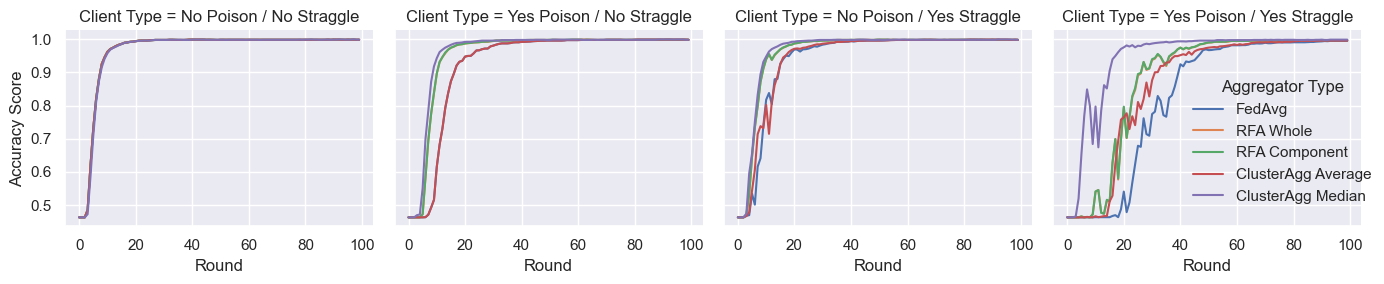

In [58]:
aggs_to_plot = [
    'fedavg',
    'rfa_whole',
    'rfa_component',
    'clusteragg_average',
    'clusteragg_median',
]


all_results = pd.concat([get_result(agg_type) for agg_type in aggs_to_plot])

grid = sns.relplot(
    data=all_results,
    x = "Round", 
    y = "Accuracy Score", 
    hue = "Aggregator Type", 
    col="Client Type", 
    kind="line",
    height=3,
    aspect = 1
)

plt.tight_layout()

In [ ]:
result_df = get_result('rfa_whole')

sns.lineplot(
    data = result_df,
    hue='Type',
    y = 'Accuracy Score',
    x = 'Round'
).set(
    ylim = (0,1.05)
)

<Axes: xlabel='Round', ylabel='# Withheld Updates'>

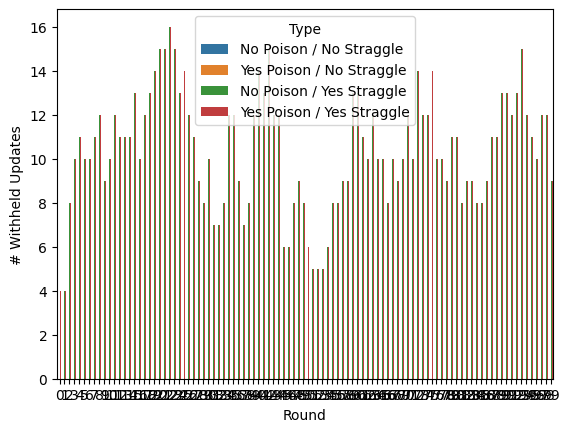

In [74]:
sns.barplot(
    data = result_df,
    hue = 'Type',
    y = '# Withheld Updates',
    x = 'Round',
)